

<h1 style="border: 2px solid black; padding: 15px; border-radius: 12px;" align='center'>Cours IA et Applications</h1>    

<h2 align='center'> Introduction au NLP </h2>

<h3 align='center'> Jordy Palafox </h3>
<h3 align='center'> Ing2 GSI/MI - 2023/2024 </h3>
      
      
<div style="display:flex"> 
    <img src="cytech.png", style="width:250px;height:50"> 
    <img src="cy.jpg", style="width:300px;height:100px"> 
</div> 

Dans ce notebook, nous ferons une première exploration dans l'**approche connexionniste**.

# Comment traiter du texte ? 

Un des premiers problèmes en NLP est la représentation du texte pour le rendre "compréhensible" par l'ordinateur.

Pour cela, on **vectorise** le texte, autrement dit on transforme le texte sous forme de tenseur.
Il existe plusieurs approches possibles : 
+ segmenter le texte en mots et chaque mot est représenté par un vecteur, 
+ segmenter le texte en caractères et chaque caractère est représenté par un vecteur, 
+ extraire des n-grammes qui sont des groupes de mots ou caractères qui se chevauchent.

*Exemple de n-grammes* : 
Prenons la phrase "Le chien joue et aboie"
2-grammes : {"Le", "Le chien", "chien joue", "joue", "joue et", "et", "et aboie", "aboie"}
On parle de **sac de mots** (**bag of words**).
    Si l'ordre ne compte pas, on peut s'intéresser à des notions de fréquences de n-grammes, c'est une approche *statistique*. Par exemple, les méthodes td-idf en font partie (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) Par exemple chercher les bi-grams donc les associations de 2 mots les plus fréquents.

On va ensuite transformer chaque unité en un token (jeton), c'est la **tokenisation** et décomposer notre texte (c'est l'*analyse lexicale* !).

On peut ensuite choisir entre deux méthodes : 
+ l'**encodage** des tokens en one-hot encoding => problème de sparsité !
+ le **plongement** de tokens (**word embedding**).

Remarque : on n'a pas encore parlé d'une autre étape de prétraitement : stemming, lemmatization, choix des stopwords (les mots communs qui n'apportent que peu d'informations au texte), retrait des majuscules etc. ça vient !

In [1]:
import tensorflow as tf 

gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        #Currenlty memory growth needs to be the same across GPUs
        for gpu in gpus :
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical devices", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical devices 1 Logical GPUs


2023-03-12 18:44:40.658142: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-12 18:44:40.746981: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-12 18:44:40.747145: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-12 18:44:40.770654: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

# Chargeons le jeu de données classiques IMDB

Ce jeu de données contient 50000 critiques polarisées de la BD Internet Movie Database.
Il est réparti de la manière suivante :
+ 25000 données d'entraînement,
+ 25000 données de test,

et 50% / 50% de labels positifs et négatifs.
Ici on se préoccupe pas de l'équilibre des classes (c'est un cas complètement idéalisé).

In [2]:
from tensorflow import keras
import pandas as pd, numpy as np

In [3]:
imdb_data = pd.read_csv('IMDB_Dataset.csv')

In [4]:
imdb_data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# Prétraitement 
On va explorer la première étape : le nettoyage du texte ! 


In [5]:
import string, re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from tqdm import tqdm
import os
stop_words =set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jordy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jordy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
# suppresion de la ponctuation, passage en minuscule, stemming, lemmatisation, stopwords

def clean_tweet(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    """
    Cette fonction va nettoyer le texte : 
    + mettre en minuscule, 
    + supprimer un certain nombre d'expression,
    + choix lemmatisation / stemming,
    + choix d'une liste de stopwords
    """
    
    text = text.lower()
    text = text.replace('\n', ' ').replace('\r', '')
    text = ' '.join(text.split())
    text = re.sub(r"[A-Za-z\.]*[0-9]+[A-Za-z%°\.]*", "", text)
    text = re.sub(r"(\s\-\s|-$)", "", text)
    text = re.sub(r"[,\!\?\%\(\)\/\"]", "", text)
    text = re.sub(r"\&\S*\s", "", text)
    text = re.sub(r"\&", "", text)
    text = re.sub(r"\+", "", text)
    text = re.sub(r"\#", "", text)
    text = re.sub(r"\$", "", text)
    text = re.sub(r"\£", "", text)
    text = re.sub(r"\%", "", text)
    text = re.sub(r"\:", "", text)
    text = re.sub(r"\@", "", text)
    text = re.sub(r"\-", "", text)
    
    ## transforme en tokens
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    
                    lst_stopwords]
                
    ## Stemming (supprime -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (retourne la racine du mot)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## liste => string
    text = " ".join(lst_text)
    return text


In [7]:
imdb_data['clean'] = imdb_data['review'].apply(lambda row : clean_tweet(row, flg_stemm=False, 
                                                      flg_lemm=True, lst_stopwords=stop_words))

In [9]:
imdb_data

,review,sentiment,clean
0,One of the other reviewers has mentioned that ...,positive,one reviewer mentioned watching oz episode hoo...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production. <br ><br >the fil...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically there's family little boy jake think...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei's love time money visually stunn...
...,...,...,...
49995,I thought this movie did a down right good job...,positive,thought movie right good job. creative origina...
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,bad plot bad dialogue bad acting idiotic direc...
49997,I am a Catholic taught in parochial elementary...,negative,catholic taught parochial elementary school nu...
49998,I'm going to have to disagree with the previou...,negative,i'm going disagree previous comment side malti...


On voit que la balise < br > est toujours présente ...
Cela dépend notamment du dictionnaire que l'on utilise pour les stopwords

In [10]:
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

Il existe d'autres listes de stopwords disponibles, par exempel Spacy en propose une :

https://spacy.io/

# On va maintenant **Tokenizer**
Keras en propose un, NLTK, Spacy, vous pouvez aussi créer le votre !

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=10000,
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                     lower=True,
                     char_level=False #si True, chaque caractère est un token
                     )

Modifions légèrement la colonne de review, postive ou negative ne sont pas interprétables par l'ordinateur.
Ainsi 0 = négatif et 1 = positif.

In [12]:
def sentiment(row):
    if row == 'positive':
        return 1
    else :
        return 0

In [13]:
imdb_data['sentiment'] = imdb_data['sentiment'].apply(lambda row : sentiment(row))

On va séparer les données en train, val et test. 

En effet, le tokenizer va être entrainé sur les données d'entraînement.
Il se peut que de nouveaux mots apparaissent, le modèle ne les connaîtra donc pas.

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
x_train, x_test, y_train, y_test = train_test_split(
    imdb_data['clean'], imdb_data['sentiment'], train_size=0.8, stratify=imdb_data['sentiment'], random_state=42)

x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, train_size=0.8 ,stratify=y_train, random_state=42)

In [16]:
print("========== Données d'entraînement ========== \n", x_train,  "\n",
      "========== Données de validation ========== \n", x_test,  "\n",
      "========== Données de test ========== \n", x_val)

========== Données d'entraînement ========== 
 26680    oh yes agree others describe appalling. acting...
16648    basic hook lincoln slow. slowness represents t...
29967    utter trash. i'm huge fan cusacks sole reason ...
34122    meet cosmo jason priestley nerdy young bookie ...
823      know people criticise show much.<br ><br >it g...
                               ...                        
6566     hey guy movie everything choices. time life mu...
7753     movie funny sad enough think kinda true. love ...
43410    movie horrible. everything done before. nothin...
47724    sweeping drama top notch acting incredible pho...
45823    italy write venice. cancelated abc given chanc...
Name: clean, Length: 32000, dtype: object 
 ========== Données de validation ========== 
 18870    yes mtv really way market daria. started cleve...
39791    story bride fair amusing engaging one filmmake...
30381    team varied scully mulder two scientist pilot ...
42294    popular movie probably humor

Entrainons le tokenizer ! 

In [17]:
tokens = tokenizer.fit_on_texts(x_train)

In [18]:
tokenizer.document_count

32000

In [19]:
tokenizer.num_words

10000

In [20]:
tokenizer.index_word

{1: 'br',
 2: 'movie',
 3: 'film',
 4: 'one',
 5: 'like',
 6: 'good',
 7: 'time',
 8: 'character',
 9: 'even',
 10: 'get',
 11: 'story',
 12: 'would',
 13: 'see',
 14: 'make',
 15: 'really',
 16: 'scene',
 17: 'well',
 18: 'much',
 19: 'bad',
 20: 'also',
 21: 'great',
 22: 'people',
 23: 'it',
 24: 'first',
 25: 'the',
 26: 'show',
 27: 'way',
 28: 'thing',
 29: 'made',
 30: 'think',
 31: 'could',
 32: 'know',
 33: 'go',
 34: 'life',
 35: 'watch',
 36: 'seen',
 37: 'many',
 38: 'love',
 39: 'two',
 40: 'plot',
 41: 'say',
 42: 'never',
 43: 'look',
 44: 'end',
 45: 'acting',
 46: 'little',
 47: 'best',
 48: 'actor',
 49: 'ever',
 50: 'better',
 51: 'year',
 52: 'come',
 53: 'still',
 54: 'take',
 55: 'work',
 56: 'man',
 57: 'find',
 58: 'i',
 59: 'something',
 60: 'give',
 61: 'part',
 62: 'lot',
 63: 'want',
 64: 'back',
 65: "i'm",
 66: 'watching',
 67: 'real',
 68: 'director',
 69: 'play',
 70: 'though',
 71: 'funny',
 72: 'another',
 73: 'performance',
 74: 'actually',
 75: 'guy'

Transforme le texte en liste de tokens pour chaque texte :

In [21]:
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_val_seq = tokenizer.texts_to_sequences(x_val)
x_test_seq = tokenizer.texts_to_sequences(x_test)

In [22]:
x_train_seq[0][:10]

[332, 339, 897, 301, 1524, 3115, 45, 585, 235, 368]

In [23]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing import sequence

On transforme ensuite les listes d'entiers en tenseur 2D d'entiers de la forme (sample, maxlen)

In [24]:
word_index = tokenizer.word_index

maxlen = 300

x_train_pad = sequence.pad_sequences(x_train_seq, maxlen=maxlen)
x_val_pad = sequence.pad_sequences(x_val_seq, maxlen=maxlen)
x_test_pad = sequence.pad_sequences(x_test_seq, maxlen=maxlen)

In [25]:
x_train_pad

array([[   0,    0,    0, ...,    9,  225,  153],
       [   0,    0,    0, ..., 3547, 4083,  361],
       [   0,    0,    0, ..., 6822,  311,  892],
       ...,
       [   0,    0,    0, ...,   58,  570,    2],
       [   0,    0,    0, ...,    4,  374,  532],
       [   0,    0,    0, ..., 3738, 7759, 2673]], dtype=int32)

# Construisons notre premier modèle 

On va réaliser un modèle extrèmement basique mais on va déjà introduire la notion d'Embedding

In [26]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

In [27]:
model = Sequential()
model.add(Embedding(10000, 8, input_length = maxlen))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 8)            80000     
                                                                 
 flatten (Flatten)           (None, 2400)              0         
                                                                 
 dense (Dense)               (None, 10)                24010     
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 104,021
Trainable params: 104,021
Non-trainable params: 0
_________________________________________________________________


A quoi correspond cette couche d'Embedding ? 

L'objectif est d'associer de manière logique un mot à un vecteur !
10000 correspond au nombre de tokens, 
8 est la dimension des vecteurs.

Voici un exemple :

In [31]:
Embedding(10000, 8, input_length = maxlen)(x_train_pad[0])

<tf.Tensor: shape=(300, 8), dtype=float32, numpy=
array([[ 0.04098922,  0.0486129 , -0.02096477, ...,  0.00372452,
         0.04070976,  0.02801653],
       [ 0.04098922,  0.0486129 , -0.02096477, ...,  0.00372452,
         0.04070976,  0.02801653],
       [ 0.04098922,  0.0486129 , -0.02096477, ...,  0.00372452,
         0.04070976,  0.02801653],
       ...,
       [ 0.04603792, -0.03834362,  0.01704124, ..., -0.00491924,
        -0.00233414, -0.01782819],
       [-0.03384489,  0.04674489,  0.0380833 , ..., -0.00775106,
        -0.01571677, -0.02950884],
       [ 0.01272687,  0.03567392, -0.00329652, ...,  0.04848282,
         0.0464983 ,  0.01285839]], dtype=float32)>

In [29]:
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=['acc'])

In [30]:
history = model.fit(x_train_pad, y_train, epochs=10, batch_size=32, validation_data=[x_val_pad, y_val])

Epoch 1/10


2023-03-12 18:45:52.458629: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1000/1000 [==============================] - 4s 2ms/step - loss: 0.4069 - acc: 0.8062 - val_loss: 0.2692 - val_acc: 0.8873
Epoch 2/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2352 - acc: 0.9057 - val_loss: 0.2701 - val_acc: 0.8870
Epoch 3/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.1965 - acc: 0.9235 - val_loss: 0.2771 - val_acc: 0.8876
Epoch 4/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.1646 - acc: 0.9383 - val_loss: 0.3005 - val_acc: 0.8813
Epoch 5/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.1313 - acc: 0.9537 - val_loss: 0.3345 - val_acc: 0.8774
Epoch 6/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0990 - acc: 0.9657 - val_loss: 0.3671 - val_acc: 0.8681
Epoch 7/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0702 - acc: 0.9770 - val_loss: 0.4374 - val_acc: 0.8643
Epoch 8/10
1000/1000 [==============================] - 2s 2ms/step - los

# Données de test ? 

In [33]:
loss, acc = model.evaluate(x_test_pad, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.7296 - acc: 0.8515


In [35]:
print(f"La perte est de {loss} et l'accuracy {acc}.")

La perte est de 0.7295742630958557 et l'accuracy 0.8514999747276306.


# Visualisation rapide

In [37]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Loss & Acc')

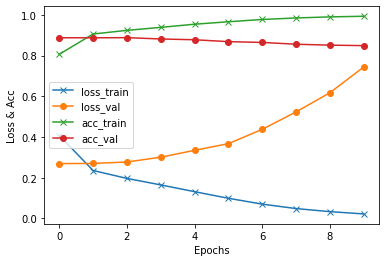

In [50]:
plt.plot(range(10),history.history['loss'], label="loss_train", marker='x')
plt.plot(range(10),history.history['val_loss'], label="loss_val", marker='o')
plt.plot(range(10),history.history['acc'], label="acc_train", marker='x')
plt.plot(range(10),history.history['val_acc'], label="acc_val", marker='o')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss & Acc')

# Comment aller plus loin ? 

Nous allons voir plusieurs pistes :
+ utiliser des embeddings de mots pré-entrainés : GloVe, Fastext, Word2Vec,
+ utiliser une architecture de réseaux ou des neurones plus appropriés !


## *Utiliser des embeddings pré-entrainés !*

## 1 . Glove

"The GloVe model is trained on the non-zero entries of a global word-word co-occurrence matrix, which tabulates how frequently words co-occur with one another in a given corpus. Populating this matrix requires a single pass through the entire corpus to collect the statistics. For large corpora, this pass can be computationally expensive, but it is a one-time up-front cost. Subsequent training iterations are much faster because the number of non-zero matrix entries is typically much smaller than the total number of words in the corpus.


The tools provided in this package automate the collection and preparation of co-occurrence statistics for input into the model. The core training code is separated from these preprocessing steps and can be executed independently."

https://nlp.stanford.edu/projects/glove/

In [58]:
import codecs

print('loading word embeddings...')

embeddings_index = {}
f = codecs.open('glove.twitter.27B/glove.twitter.27B.200d.txt', encoding='utf-8')

for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('found %s word vectors' % len(embeddings_index))


loading word embeddings...


1193518it [00:50, 23617.52it/s]

found 1193515 word vectors


In [60]:
from keras.layers import Dropout

In [80]:
words_not_found = []
embed_dim = 200 
MAX_NB_WORDS = 10000
max_seq_len = 300
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)

    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' %
      np.sum(np.sum(embedding_matrix, axis=1) == 0))
      
      
model_glove = tf.keras.Sequential()

model_glove.add(Embedding(nb_words,embed_dim,input_length=max_seq_len, weights=[embedding_matrix],trainable=False))
model_glove.add(Flatten())
model_glove.add(Dense(32,activation='relu'))
model_glove.add(Dense(1,activation='sigmoid'))
model_glove.summary()     

number of null word embeddings: 271
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 300, 200)          2000000   
                                                                 
 flatten_3 (Flatten)         (None, 60000)             0         
                                                                 
 dense_6 (Dense)             (None, 32)                1920032   
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,920,065
Trainable params: 1,920,065
Non-trainable params: 2,000,000
_________________________________________________________________


In [81]:
from tensorflow.keras.callbacks import EarlyStopping
es_callback = EarlyStopping(monitor='val_loss', patience=5)

In [82]:
model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_glove = model.fit(x_train_pad, y_train, batch_size=16,
          epochs=15, validation_data=(x_val_pad, y_val), callbacks=[es_callback], shuffle=False)

Epoch 1/15
2000/2000 [==============================] - 5s 2ms/step - loss: 0.0038 - acc: 0.9988 - val_loss: 1.6763 - val_acc: 0.8199
Epoch 2/15
2000/2000 [==============================] - 5s 2ms/step - loss: 0.0024 - acc: 0.9991 - val_loss: 1.8126 - val_acc: 0.8180
Epoch 3/15
2000/2000 [==============================] - 5s 3ms/step - loss: 0.0015 - acc: 0.9994 - val_loss: 2.1763 - val_acc: 0.8035
Epoch 4/15
2000/2000 [==============================] - 5s 3ms/step - loss: 7.1739e-04 - acc: 0.9997 - val_loss: 2.3199 - val_acc: 0.8058
Epoch 5/15
2000/2000 [==============================] - 5s 3ms/step - loss: 2.9087e-04 - acc: 0.9998 - val_loss: 2.5163 - val_acc: 0.8001
Epoch 6/15
2000/2000 [==============================] - 5s 2ms/step - loss: 1.4254e-04 - acc: 1.0000 - val_loss: 2.7243 - val_acc: 0.7958


In [83]:
loss, acc = model_glove.evaluate(x_test_pad, y_test)

print(f"La perte est de {loss} et l'accuracy {acc}.")

313/313 [==============================] - 0s 1ms/step - loss: 0.7071 - accuracy: 0.5048
La perte est de 0.7071151733398438 et l'accuracy 0.504800021648407.


Text(0, 0.5, 'Loss & Acc')

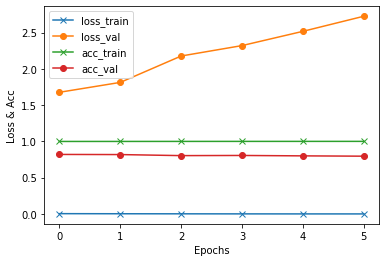

In [85]:
plt.plot(range(6),history_glove.history['loss'], label="loss_train", marker='x')
plt.plot(range(6),history_glove.history['val_loss'], label="loss_val", marker='o')
plt.plot(range(6),history_glove.history['acc'], label="acc_train", marker='x')
plt.plot(range(6),history_glove.history['val_acc'], label="acc_val", marker='o')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss & Acc')

## 2. Fastext

Voir ici :
https://fasttext.cc/ 

In [88]:
print('loading word embeddings...')

embeddings_index = {}
f = codecs.open('wiki-news-300d-1M.vec', encoding='utf-8')

for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('found %s word vectors' % len(embeddings_index))


words_not_found = []
embed_dim = 300 
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)

    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' %
      np.sum(np.sum(embedding_matrix, axis=1) == 0))
      
      
#training params
batch_size = 16 
num_epochs = 40

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

model_fastext = tf.keras.Sequential()

model_fastext.add(Embedding(nb_words,embed_dim,input_length=max_seq_len, weights=[embedding_matrix],trainable=False))
model_fastext.add(Flatten())
model_fastext.add(Dense(32,activation='relu'))
model_fastext.add(Dropout(0.4))
model_fastext.add(Dense(1,activation='sigmoid'))
model_fastext.summary()  

loading word embeddings...


999995it [00:52, 19067.14it/s]


found 999995 word vectors
number of null word embeddings: 473
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 300, 300)          3000000   
                                                                 
 flatten_4 (Flatten)         (None, 90000)             0         
                                                                 
 dense_8 (Dense)             (None, 32)                2880032   
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5,880,065
Trainable params: 2,880,065
Non-trainable params: 3,000,000
________________________________________

In [90]:
model_fastext.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_fastext = model_fastext.fit(x_train_pad, y_train, batch_size=16,
          epochs=15, validation_data=(x_val_pad, y_val), callbacks=[es_callback], shuffle=False)
                   

Epoch 1/15
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5754 - accuracy: 0.6913 - val_loss: 0.4599 - val_accuracy: 0.7854
Epoch 2/15
2000/2000 [==============================] - 4s 2ms/step - loss: 0.4130 - accuracy: 0.8051 - val_loss: 0.4087 - val_accuracy: 0.8141
Epoch 3/15
2000/2000 [==============================] - 4s 2ms/step - loss: 0.3332 - accuracy: 0.8471 - val_loss: 0.4246 - val_accuracy: 0.8140
Epoch 4/15
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2730 - accuracy: 0.8749 - val_loss: 0.4283 - val_accuracy: 0.8116
Epoch 5/15
2000/2000 [==============================] - 3s 2ms/step - loss: 0.2326 - accuracy: 0.8927 - val_loss: 0.5105 - val_accuracy: 0.8152
Epoch 6/15
2000/2000 [==============================] - 3s 2ms/step - loss: 0.2093 - accuracy: 0.9055 - val_loss: 0.5296 - val_accuracy: 0.8098
Epoch 7/15
2000/2000 [==============================] - 3s 2ms/step - loss: 0.1911 - accuracy: 0.9105 - val_loss: 0.5314 - val_accuracy:

In [92]:
loss, acc = model_fastext.evaluate(x_test_pad, y_test)

print(f"La perte est de {loss} et l'accuracy {acc}.")

313/313 [==============================] - 0s 1ms/step - loss: 0.5370 - accuracy: 0.7947
La perte est de 0.5370049476623535 et l'accuracy 0.794700026512146.


Text(0, 0.5, 'Loss & Acc')

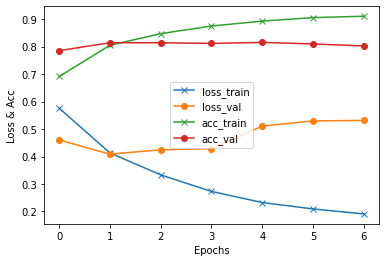

In [95]:
plt.plot(range(7),history_fastext.history['loss'], label="loss_train", marker='x')
plt.plot(range(7),history_fastext.history['val_loss'], label="loss_val", marker='o')
plt.plot(range(7),history_fastext.history['accuracy'], label="acc_train", marker='x')
plt.plot(range(7),history_fastext.history['val_accuracy'], label="acc_val", marker='o')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss & Acc')

L'amélioration est significative !

Pour aller plus loin, voir ce medium qui les compare.
Vous verrez aussi comment ils ont été concus !

https://levelup.gitconnected.com/glove-and-fasttext-clearly-explained-extracting-features-from-text-data-1d227ab017b2

## 3. Word2Vec

Une dernière idée est de créer son propre plongement, je vous renvoie ici : 

https://radimrehurek.com/gensim/index.html

# On a parlé des embeddings, maintenant allons plus loin les neurones.
# Nous allons voir : RNN, LSTM, Bert et les transformers brièvement 

## Les réseaux récurrents

Les parties qui suivent sont librement inspirées (voir un peu plus du cours d'Introduction au deep learning de J.Rynkiewicz. On utilise aussi comme depuis le debut de le livre de François Chollet L'apprentissage profond avec Python édition machinelearning.fr / manning .

### Les RNN

L'idée des RNN est d'introduire une notion de temps dans l'algorithme.

On note :
+ $X_t$ l'observation au cours du temps, 
+ $h_t$ le vecteur d'état caché du réseau ,
+ $Y_t$ la sortie au temps $t$,
+ $\theta$ le vecteur des poids du modèles.

Comme tout réseau, le modèle est initialisé avec un vecteur d'état caché $h_0$. On peut alors visualiser le réseau comme un système dynamique :
$$
\left\{
    \begin{array}{ll}
        h_t = g_\theta(h_{t-1},X_t) \\
        Y_t = f_\theta(h_t)
    \end{array}
\right.
$$

<img src="rnn_simple.png" 
        alt="Picture" 
        style="display: block; margin: 0 auto" />
        
        
<img src="rnn_complet.png" 
        alt="Picture" 
        style="display: block; margin: 0 auto" />
        
Cela permet par exemple d'introduire une notion d'ordre des mots dans les textes. 

In [105]:
model_rnn = Sequential()

model_rnn.add(Embedding(10000, 32))
model_rnn.add(keras.layers.SimpleRNN(32))
model_rnn.add(Dense(1, activation='sigmoid'))

model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])


history_rnn = model_rnn.fit(x_train_pad, y_train,
                   epochs=5,
                   batch_size=16,
                   validation_data=(x_val_pad, y_val))

Epoch 1/5
2000/2000 [==============================] - 269s 134ms/step - loss: 0.5139 - acc: 0.7411 - val_loss: 0.4346 - val_acc: 0.8179
Epoch 2/5
2000/2000 [==============================] - 279s 139ms/step - loss: 0.4612 - acc: 0.7812 - val_loss: 0.4961 - val_acc: 0.7590
Epoch 3/5
2000/2000 [==============================] - 267s 134ms/step - loss: 0.2996 - acc: 0.8781 - val_loss: 0.3807 - val_acc: 0.8544
Epoch 4/5
2000/2000 [==============================] - 269s 134ms/step - loss: 0.2333 - acc: 0.9088 - val_loss: 0.4259 - val_acc: 0.8281
Epoch 5/5
2000/2000 [==============================] - 271s 135ms/step - loss: 0.1754 - acc: 0.9376 - val_loss: 0.4645 - val_acc: 0.8369


In [108]:
loss, acc = model_rnn.evaluate(x_test_pad, y_test)
print("loss :", loss, " et acc :", acc)

313/313 [==============================] - 10s 32ms/step - loss: 0.4399 - acc: 0.8451
loss : 0.4399109482765198  et acc : 0.8450999855995178


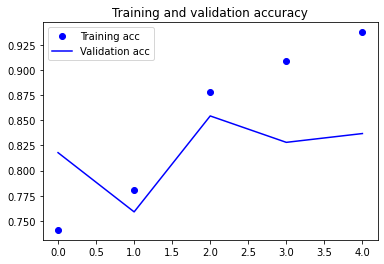

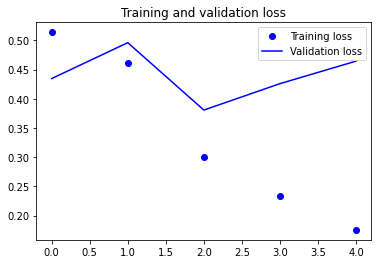

In [106]:
acc = history_rnn.history['acc']
val_acc = history_rnn.history['val_acc']
loss = history_rnn.history['loss']
val_loss = history_rnn.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Plusieurs remarques : 
+ les scores sont bons, 
+ c'est long à entraîner, 
+ On pourrait certainement avoir un bien meilleur score.

On va introduire de façon très légère une généralisation des RNN : les neurones LSTM via un schéma puis mettre en pratique.

Il existe aussi les neurones GRU et les versions Bidirectionnelles : on lit les documents dans le sens de lecture et le sens inverse pour améliorer les performances.

<img src="lstm_simple.png" 
        alt="Picture" 
        style="display: block; margin: 0 auto" />
        
        Un réseau LSTM simplifié !
        On rajoute un canal d'information avec la "retenue".

In [110]:
model_lstm = Sequential()

model_lstm.add(Embedding(10000, 32))
model_lstm.add(keras.layers.LSTM(32))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(60, activation='relu'))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

history_lstm = model_lstm.fit(x_train_pad, y_train,
                   epochs=20,
                   batch_size=16,
                   validation_data=(x_val_pad, y_val),
                   callbacks=[es_callback])

Epoch 1/20


2023-03-12 23:30:07.274118: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302


2000/2000 [==============================] - 23s 10ms/step - loss: 0.3586 - acc: 0.8444 - val_loss: 0.2814 - val_acc: 0.8856
Epoch 2/20
2000/2000 [==============================] - 20s 10ms/step - loss: 0.2322 - acc: 0.9118 - val_loss: 0.3090 - val_acc: 0.8813
Epoch 3/20
2000/2000 [==============================] - 20s 10ms/step - loss: 0.1773 - acc: 0.9349 - val_loss: 0.3133 - val_acc: 0.8734
Epoch 4/20
2000/2000 [==============================] - 20s 10ms/step - loss: 0.1299 - acc: 0.9544 - val_loss: 0.3855 - val_acc: 0.8706
Epoch 5/20
2000/2000 [==============================] - 20s 10ms/step - loss: 0.0973 - acc: 0.9671 - val_loss: 0.4054 - val_acc: 0.8655
Epoch 6/20
2000/2000 [==============================] - 21s 10ms/step - loss: 0.1032 - acc: 0.9646 - val_loss: 0.4996 - val_acc: 0.8648


In [111]:
model_lstm.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, None, 32)          320000    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 60)                1980      
                                                                 
 dense_13 (Dense)            (None, 1)                 61        
                                                                 
Total params: 330,361
Trainable params: 330,361
Non-trainable params: 0
_________________________________________________________________


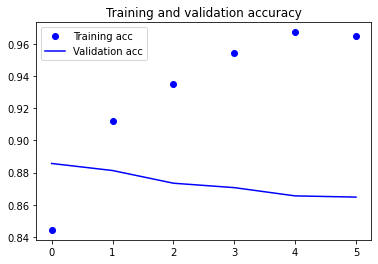

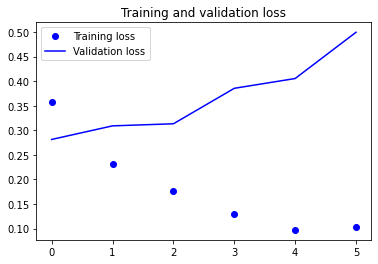

In [112]:
acc = history_lstm.history['acc']
val_acc = history_lstm.history['val_acc']
loss = history_lstm.history['loss']
val_loss = history_lstm.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [114]:
loss, acc = model_lstm.evaluate(x_test_pad, y_test)
print("loss :", loss, " et acc :", acc)

313/313 [==============================] - 2s 5ms/step - loss: 0.4666 - acc: 0.8723
loss : 0.4665846824645996  et acc : 0.8723000288009644


# Un peu de transfert learning avec les transformers

Pour rappels les transformers sont des réseaux de neurones particuliers de type encoder-decoder 
avec des couches utilisant le phénomène d'attention.
C'est cela qui a permis une révolution du NLP à partir de 2017.

Pour plus d'infos : l'an prochain !

In [119]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import pipeline

In [120]:
model_name = 'distilbert-base-uncased-finetuned-sst-2-english'
# le modèle n'existe qu'en PyTorch , on utilise from_pt pour l'importer en tensorflow
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english and are newly initialized: ['dropout_42']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [121]:
from sklearn.metrics import classification_report

In [123]:
x_train[0]

"one reviewer mentioned watching oz episode hooked. right exactly happened me.<br ><br >the first thing struck oz brutality unflinching scene violence set right word go. trust show faint hearted timid. show pull punch regard drug sex violence. hardcore classic use word.<br ><br >it called oz nickname given oswald maximum security state penitentary. focus mainly emerald city experimental section prison cell glass front face inwards privacy high agenda. em city home many..aryans muslim gangsta latino christian italian irish more....so scuffle death stare dodgy dealing shady agreement never far away.<br ><br >i would say main appeal show due fact go show dare. forget pretty picture painted mainstream audience forget charm forget romance...oz mess around. first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high level graphic violence. violence injustice crooked guard who'll sold nickel inmate who'll kill order get away well mannered middle class 

In [122]:
classifier(x_train[0])

[{'label': 'NEGATIVE', 'score': 0.9823893308639526}]

In [124]:
def labeling(text):
    if text == 'NEGATIVE':
        return 0
    elif text == 'POSITIVE':
        return 1

In [127]:
from tqdm import tqdm

In [137]:
y_pred = []
indices = []
for i in range(500):
    try:
        c = classifier(x_train[i])
        indices.append(i)
        y_pred.append(c)
    except:
        pass

In [138]:
y_pred

[[{'label': 'NEGATIVE', 'score': 0.9823893308639526}],
 [{'label': 'POSITIVE', 'score': 0.9533429741859436}],
 [{'label': 'NEGATIVE', 'score': 0.9983161687850952}],
 [{'label': 'POSITIVE', 'score': 0.539603054523468}],
 [{'label': 'NEGATIVE', 'score': 0.9993703961372375}],
 [{'label': 'NEGATIVE', 'score': 0.9995279312133789}],
 [{'label': 'POSITIVE', 'score': 0.9997218251228333}],
 [{'label': 'NEGATIVE', 'score': 0.9002212285995483}],
 [{'label': 'POSITIVE', 'score': 0.9221720099449158}],
 [{'label': 'NEGATIVE', 'score': 0.985028862953186}],
 [{'label': 'NEGATIVE', 'score': 0.915774405002594}],
 [{'label': 'POSITIVE', 'score': 0.9964448809623718}],
 [{'label': 'NEGATIVE', 'score': 0.9995595812797546}],
 [{'label': 'NEGATIVE', 'score': 0.9824764728546143}],
 [{'label': 'NEGATIVE', 'score': 0.9807927012443542}],
 [{'label': 'NEGATIVE', 'score': 0.9993732571601868}],
 [{'label': 'NEGATIVE', 'score': 0.9989207983016968}],
 [{'label': 'NEGATIVE', 'score': 0.777123749256134}],
 [{'label': 'N

In [139]:
y_pred = [y_pred[i][0]['label'] for i in range(len(y_pred))]
y_pred = [labeling(y_pred[i]) for i in range(len(y_pred))]

Ici il n'y a même pas besoin de préprocessing !

In [140]:
print(classification_report(y_train[indices], y_pred))

              precision    recall  f1-score   support

           0       0.79      0.94      0.86       162
           1       0.91      0.72      0.81       147

    accuracy                           0.83       309
   macro avg       0.85      0.83      0.83       309
weighted avg       0.85      0.83      0.83       309



# Finissons sur Bert le game changer

https://www.quantmetry.com/glossaire/bert-nlp/
https://datascientest.com/bert-un-outil-de-traitement-du-langage-innovant
https://fr.wikipedia.org/wiki/BERT_(mod%C3%A8le_de_langage)

Mais surtout : https://arxiv.org/pdf/1810.04805.pdf

In [141]:
num_classes = 2

In [142]:
from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=num_classes)

/home/jordy/anaconda3/envs/tensorflow/lib/python3.9/site-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(


loading file vocab.txt from cache at /home/jordy/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /home/jordy/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/tokenizer_config.json


loading configuration file config.json from cache at /home/jordy/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading configuration file config.json from cache at /home/jordy/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb42

loading weights file tf_model.h5 from cache at /home/jordy/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/tf_model.h5
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [143]:
sentences = x_train
labels = y_train
len(sentences),len(labels)

(32000, 32000)

In [145]:
input_ids=[]
attention_masks=[]

for sent in tqdm(sentences):
    bert_inp=bert_tokenizer.encode_plus(sent,add_special_tokens = True,
                                        max_length =64,pad_to_max_length = True,
                                        return_attention_mask = True,
                                        truncation=True)
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(labels)


 28%|██████████▌                          | 9113/32000 [00:20<00:48, 470.24it/s]


 57%|████████████████████▌               | 18305/32000 [00:41<00:30, 451.58it/s]


 86%|███████████████████████████████     | 27629/32000 [01:01<00:09, 453.81it/s]


100%|████████████████████████████████████| 32000/32000 [01:11<00:00, 446.11it/s]


In [146]:
import pickle

print('Preparing the pickle file.....')

pickle_inp_path='./bert_inp.pkl'
pickle_mask_path='./bert_mask.pkl'
pickle_label_path='./bert_label.pkl'

pickle.dump((input_ids),open(pickle_inp_path,'wb'))
pickle.dump((attention_masks),open(pickle_mask_path,'wb'))
pickle.dump((labels),open(pickle_label_path,'wb'))


print('Pickle files saved as ',pickle_inp_path,pickle_mask_path,pickle_label_path)

Preparing the pickle file.....
Pickle files saved as  ./bert_inp.pkl ./bert_mask.pkl ./bert_label.pkl


In [147]:
print('Loading the saved pickle files..')

input_ids=pickle.load(open(pickle_inp_path, 'rb'))
attention_masks=pickle.load(open(pickle_mask_path, 'rb'))
labels=pickle.load(open(pickle_label_path, 'rb'))

print('Input shape {} Attention mask shape {} Input label shape {}'.format(input_ids.shape,attention_masks.shape,labels.shape))

Loading the saved pickle files..
Input shape (32000, 64) Attention mask shape (32000, 64) Input label shape (32000,)


In [148]:

train_inp, val_inp, train_label, val_label, train_mask, val_mask = train_test_split(
    input_ids, labels, attention_masks, test_size=0.2, stratify=labels ,random_state=42)

print('Train inp shape {} Val input shape {}\nTrain label shape {} Val label shape {}\nTrain attention mask shape {} Val attention mask shape {}'.format(
    train_inp.shape, val_inp.shape, train_label.shape, val_label.shape, train_mask.shape, val_mask.shape))

Train inp shape (25600, 64) Val input shape (6400, 64)
Train label shape (25600,) Val label shape (6400,)
Train attention mask shape (25600, 64) Val attention mask shape (6400, 64)


In [149]:
model_save_path='./bert_model.h5'

log_dir='tensorboard_data/tb_bert'

In [150]:
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path, save_weights_only=True,
                                                monitor='val_loss', mode='min', save_best_only=True), tf.keras.callbacks.TensorBoard(log_dir=log_dir)]

print('\nBert Model', bert_model.summary())

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)

bert_model.compile(loss=loss, optimizer=optimizer, metrics=[metric])

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_80 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________

Bert Model None


ET OUI QUASIMENT 110 MILLIONS DE PARAMÈTRES!

In [151]:
history = bert_model.fit([train_inp, train_mask], train_label, batch_size=32,
                         epochs=4, validation_data=([val_inp, val_mask], val_label), callbacks=callbacks)

Epoch 1/4


  0%|▏                                      | 2/500 [15:32<64:31:13, 466.41s/it]


800/800 [==============================] - 157s 185ms/step - loss: 0.4143 - accuracy: 0.8052 - val_loss: 0.3544 - val_accuracy: 0.8405
Epoch 2/4
800/800 [==============================] - 147s 184ms/step - loss: 0.2795 - accuracy: 0.8810 - val_loss: 0.3435 - val_accuracy: 0.8481
Epoch 3/4
800/800 [==============================] - 143s 178ms/step - loss: 0.1608 - accuracy: 0.9373 - val_loss: 0.4201 - val_accuracy: 0.8472
Epoch 4/4
800/800 [==============================] - 143s 179ms/step - loss: 0.0817 - accuracy: 0.9720 - val_loss: 0.5454 - val_accuracy: 0.8422


In [152]:
model_save_path='./bert_model.h5'

trained_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)
trained_model.compile(loss=loss,optimizer=optimizer, metrics=[metric])
trained_model.load_weights(model_save_path)

preds = trained_model.predict([val_inp,val_mask],batch_size=32)

pred_labels = np.argmax(preds[0], axis=1)

print('Classification Report')
print(classification_report(val_label,pred_labels))

print('Training and saving built model.....')

loading configuration file config.json from cache at /home/jordy/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file tf_model.h5 from cache at /home/jordy/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/tf_model.h5
All model checkpoint layers wer

Classification Report
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      3200
           1       0.86      0.84      0.85      3200

    accuracy                           0.85      6400
   macro avg       0.85      0.85      0.85      6400
weighted avg       0.85      0.85      0.85      6400

Training and saving built model.....


Pour aller plus voir et découvrir les autres taches du NLP comme les NER, voir : 
    https://keras.io/